# ***Instalando as bibliotecas necessárias***

## *Instalando as bibliotecas Python*

In [ ]:
# Instala a biblioteca rpy2, que permite executar código R dentro do ambiente Python (Jupyter).
!pip install -q rpy2

In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.4 MB/s eta 0:00:00


In [ ]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 3.9 MB/s eta 0:00:00


## *Instalando os pacotes R*

In [ ]:
# Habilita o uso das mágicas %R e %%R para rodar código R diretamente em células do notebook.
%load_ext rpy2.ipython

In [ ]:
# Instala o pacote R inaparc, que fornece métodos de inicialização para algoritmos de clusterização fuzzy.
%%R
install.packages("inaparc", repos = "https://cloud.r-project.org/")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘kpeaks’, ‘lhs’

trying URL 'https://cloud.r-project.org/src/contrib/kpeaks_1.1.0.tar.gz'
trying URL 'https://cloud.r-project.org/src/contrib/lhs_1.2.0.tar.gz'
trying URL 'https://cloud.r-project.org/src/contrib/inaparc_1.2.0.tar.gz'

The downloaded source packages are in
	‘/tmp/RtmpdVk26f/downloaded_packages’


In [ ]:
# Instala o pacote R ppclust, que implementa algoritmos de clusterização fuzzy como FCM e GK.
%%R
install.packages("ppclust", repos = "https://cloud.r-project.org/")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cloud.r-project.org/src/contrib/ppclust_1.1.0.1.tar.gz'
Content type 'application/x-gzip' length 3885504 bytes (3.7 MB)
downloaded 3.7 MB


The downloaded source packages are in
	‘/tmp/RtmpdVk26f/downloaded_packages’


# ***Importando as bibliotecas necessárias***

In [ ]:
import pandas as pd
import numpy as np

import time

from typing import Union, Tuple, Optional, List, Literal

from numpy import linalg as la
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error

import plotly.graph_objects as go
import plotly.express as px

from rpy2.robjects import pandas2ri, globalenv   # Importa utilitários para converter objetos pandas e acessar o ambiente global do R
import rpy2.robjects as robjects                 # Importa o módulo principal para manipular objetos R no Python

from rpy2.robjects import r

from scipy.stats.mstats import winsorize

from skopt import gp_minimize
from skopt.space import Integer
from skopt.utils import use_named_args

from deap import base, creator, tools, algorithms
import random

from google.colab import files

# ***Setando os parâmetros do modelo***

In [ ]:
params = {
    'filepath': 'dataBTC.xlsx',  # Caminho do arquivo '.xlsx' com os dados de entrada.

    'delay': 2,  # Número de atrasos (lags) usados como entrada para o modelo fuzzy. Ex: para delay=5, usa-se x[t-1] a x[t-5].

    'rules_number': 3,  # Número de regras fuzzy a serem utilizadas no modelo. Cada regra representa uma "região" do espaço de entrada.

    'alfa': 1000,  # Valor inicial para a matriz de ganho P0 = alfa * I no algoritmo de mínimos quadrados recursivo (equação 11).
                   # Um valor grande permite atualizações maiores no início do treinamento.

    'lamb': 0.99,  # Fator de esquecimento (λ) que regula a influência dos dados antigos na atualização dos coeficientes.
                   # Valores próximos de 1 consideram o histórico mais fortemente.

    'n': 999,   # Índice (linha) do último dado usado no conjunto de treinamento (inclusive).
    'm': 2524,  # Índice (linha) do último dado considerado no teste (inclusive).

    'kz': None,  # Constante do kernel gaussiano (define a intensidade de ativação).

    'zs': None   # Constante do kernel gaussiano (controla a largura da ativação).
}

In [ ]:
# Atribuição direta dos parâmetros a variáveis para facilitar o uso posterior no código

filepath = params['filepath']  # Caminho do arquivo de dados

delay = params['delay']  # Número de atrasos usados como entrada

rules_number = params['rules_number']  # Número de regras fuzzy

alfa = params['alfa']  # Valor inicial da matriz de ganho (P0)

lamb = params['lamb']  # Fator de esquecimento no algoritmo de atualização

n = params['n']  # Último índice da base de treinamento

m = params['m']  # Último índice da base de teste

kz = params['kz']  # Constante do kernel gaussiano (define a intensidade de ativação).

zs = params['zs']  # Constante do kernel gaussiano (controla a largura da ativação).

# Cálculo de constantes do kernel Gaussiano (se necessário) para uso nas equações de atualização

if kz is None:
    kc = 1 / np.sqrt(2 * np.pi)
    ze = 1.0
    kz = kc / (ze ** 3)

if zs is None:
    ze = 1.0
    zs = 1 / (2 * ze ** 2)

# ***Declarando algumas funções que serão úteis nessa implementação***

## *Funções de plot*

In [ ]:
def plot_line_series(
        series: Union[pd.Series, np.ndarray],
        xlabel:str = 'x',
        ylabel:str = 'y',
        title:str = 'Line Plot',
        label:str='Series'
    ) -> None:

    """
        Description:
            Plota uma série temporal ou sequência de valores como gráfico de linha.

        Args:
            series (pd.Series | np.ndarray): Sequência de valores a serem plotados.
            xlabel (str) [opcional]: Rótulo do eixo x. [Padrão: 'x'.]
            ylabel (str) [opcional]: Rótulo do eixo y. [Padrão: 'y'.]
            title (str) [opcional]: Título do gráfico. [Padrão: 'Line Plot'.]
            label (str) [opcional]: Legenda da série. [Padrão: 'Series'].

        Return:
            A função não retorna nada, apenas exibe um gráfico.
    """


    plt.figure() # Cria uma nova figura para o gráfico

    plt.plot(series, label=label) # Plota a série no gráfico com a legenda definida

    plt.xlabel(xlabel) # Define o rótulo do eixo x

    plt.ylabel(ylabel) # Define o rótulo do eixo y

    plt.title(title) # Define o título do gráfico

    plt.legend() # Exibe a legenda no gráfico

    plt.show() # Exibe o gráfico gerado

In [ ]:
def plot_comparison_series(
    series_a: Union[pd.Series, np.ndarray],
    series_b: Union[pd.Series, np.ndarray],
    xlabel: str = 'x',
    ylabel: str = 'y',
    title: str = 'Comparison Plot',
    legend_labels: Tuple[str, str] = ('Series A', 'Series B'),
    ylim: Union[Tuple[float, float], None] = None
) -> None:
    """
        Description:
            Plota duas séries temporais (por exemplo, para fins comparativos) em um gráfico de linha.

        Args:
            series_a (pd.Series | np.ndarray): Primeira série a ser plotada.
            series_b (pd.Series | np.ndarray): Segunda série a ser plotada.
            xlabel (str) [opcional]: Rótulo do eixo x. [Padrão: 'x'.]
            ylabel (str) [opcional]: Rótulo do eixo y. [Padrão: 'y'.]
            title (str) [opcional]: Título do gráfico. [Padrão: 'Comparison Plot'.]
            legend_labels (tuple[str, str]) [opcional]: Rótulos para a legenda das duas séries. [Padrão: ('Series A', 'Series B').]
            ylim (tuple[float, float] | None) [opcional]: Limites do eixo y. [Padrão: None.]

        Return:
            A função não retorna nada, apenas exibe um gráfico comparativo.
    """

    plt.figure()  # Cria uma nova figura para o gráfico

    plt.plot(series_a, label=legend_labels[0])  # Plota a primeira série
    plt.plot(series_b, label=legend_labels[1])  # Plota a segunda série

    plt.xlabel(xlabel)  # Define o rótulo do eixo x
    plt.ylabel(ylabel)  # Define o rótulo do eixo y
    plt.title(title)  # Define o título do gráfico

    if ylim:
        plt.ylim(ylim)  # Define os limites do eixo y, se especificado

    plt.legend(loc='upper right')  # Adiciona a legenda no canto superior direito
    plt.show()  # Exibe o gráfico gerado

In [ ]:
def ellipse_points(center, cov, n_points=100, std_devs=2):
    """
    Gera pontos para desenhar uma elipse baseada na matriz de covariância.

    Args:
        center: Centro da elipse (array 1D de tamanho 2)
        cov: Matriz de covariância (2x2)
        n_points: Número de pontos da elipse
        std_devs: Número de desvios padrão para o tamanho da elipse

    Returns:
        Array de pontos da elipse (n_points x 2)
    """
    eigenvals, eigenvecs = np.linalg.eigh(cov)

    # Ângulos para gerar a elipse
    angles = np.linspace(0, 2*np.pi, n_points)

    # Gera pontos da elipse unitária
    ellipse = np.column_stack([np.cos(angles), np.sin(angles)])

    # Escala pelos eigenvalues e rotaciona pelos eigenvectors
    ellipse = ellipse @ np.diag(np.sqrt(eigenvals) * std_devs) @ eigenvecs.T

    # Translada para o centro
    ellipse += center

    return ellipse

In [ ]:
def plot_gk_clusters_2D(
    X_train: pd.DataFrame,
    centers: np.ndarray,
    memberships: np.ndarray
) -> List[go.Figure]:
    """
    Description:
        Plota múltiplos gráficos 2D do resultado do clustering Gustafson-Kessel.
        Cada gráfico destaca um cluster específico com opacidades proporcionais à pertinência fuzzy.
        Inclui barra de cor lateral e tooltip com percentual de pertencimento.

    Args:
        X_train (pd.DataFrame): DataFrame com colunas 'lag1' e 'lag2'.
        centers (np.ndarray): Centros dos clusters (k x 2).
        memberships (np.ndarray): Matriz de pertinência fuzzy (n x k).

    Return:
        List[go.Figure]: Lista de objetos go.Figure, um para cada cluster.
    """
    colorscale = 'Viridis'
    n_clusters = centers.shape[0]
    figs = []

    for k in range(n_clusters):
        fig = go.Figure()

        # Calcula as pertinências para o cluster atual
        cluster_memberships = memberships[:, k]
        membership_percentages = cluster_memberships * 100

        # Adiciona os pontos com cor e opacidade proporcional à pertinência ao cluster k
        fig.add_trace(go.Scatter(
            x=X_train['lag1'],
            y=X_train['lag2'],
            mode='markers',
            marker=dict(
                color=cluster_memberships,  # Cor baseada na pertinência
                colorscale=colorscale,
                size=6,
                opacity=cluster_memberships,  # Opacidade proporcional à pertinência
                colorbar=dict(
                    title=dict(
                        text='Pertinência ao Cluster',
                        font=dict(size=12)
                    ),
                    tickvals=[0, 0.25, 0.5, 0.75, 1.0],
                    ticktext=['0%', '25%', '50%', '75%', '100%'],
                    len=0.8,  # Altura da barra de cor
                    thickness=15,  # Espessura da barra de cor
                    x=1.02,  # Posição horizontal
                ),
                cmin=0,  # Valor mínimo da escala de cor (escala absoluta)
                cmax=1,  # Valor máximo da escala de cor (escala absoluta)
                line=dict(width=0.5, color='rgba(0,0,0,0.3)')  # Borda suave nos pontos
            ),
            customdata=np.stack([
                X_train['lag1'].values,
                X_train['lag2'].values,
                membership_percentages  # Percentual de pertencimento
            ], axis=1),
            hovertemplate=(
                '<b>Ponto %{pointNumber}</b><br>' +
                'Vol<sub>t-1</sub>: %{customdata[0]:.3f}<br>' +
                'Vol<sub>t-2</sub>: %{customdata[1]:.3f}<br>' +
                '<b>Pertinência ao Cluster ' + str(k+1) + ': %{customdata[2]:.1f}%</b>' +
                '<extra></extra>'  # Remove a caixinha padrão do plotly
            ),
            name=f'Pontos do Cluster {k+1}'
        ))

        # Cálculo da matriz de covariância com pesos fuzzy para o cluster k
        center = centers[k]
        members = memberships[:, k]
        diffs = X_train.values - center
        cov = np.cov(diffs.T, aweights=members)

        # Geração da elipse para o cluster k
        ellipse = ellipse_points(center, cov)
        fig.add_trace(go.Scatter(
            x=ellipse[:, 0],
            y=ellipse[:, 1],
            mode='lines',
            line=dict(color='black', width=2),
            hoverinfo='skip',
            showlegend=False,
            name='Contorno do Cluster'
        ))

        # Centro com anotação
        fig.add_trace(go.Scatter(
            x=[center[0]],
            y=[center[1]],
            mode='markers+text',
            marker=dict(
                color='red',
                size=12,
                symbol='x',
                line=dict(width=2, color='darkred')
            ),
            text=[f'C{k+1}'],
            textposition='top center',
            textfont=dict(size=12, color='darkred'),
            hovertemplate=(
                f"<b>Centro do Cluster {k+1}</b><br>" +
                "Vol<sub>t-1</sub>: %{x:.3f}<br>" +
                "Vol<sub>t-2</sub>: %{y:.3f}" +
                "<extra></extra>"
            ),
            showlegend=False,
            name=f'Centro {k+1}'
        ))

        # Estatísticas do cluster para o título
        avg_membership = np.mean(cluster_memberships) * 100
        max_membership = np.max(cluster_memberships) * 100
        n_high_membership = np.sum(cluster_memberships > 0.5)

        # Layout refinado
        fig.update_layout(
            xaxis=dict(
                title=dict(
                    text='Vol<sub>t-1</sub>',
                    font=dict(size=14)
                ),
                gridcolor='lightgray',
                gridwidth=0.5
            ),
            yaxis=dict(
                title=dict(
                    text='Vol<sub>t-2</sub>',
                    font=dict(size=14)
                ),
                gridcolor='lightgray',
                gridwidth=0.5
            ),
            title=dict(
                text=(
                    f'<b>Cluster {k+1} - Visualização Fuzzy</b><br>' +
                    f'<span style="font-size:12px;">Pertinência Média: {avg_membership:.1f}% | ' +
                    f'Máxima: {max_membership:.1f}% | ' +
                    f'Pontos com >50%: {n_high_membership}</span>'
                ),
                x=0.5,
                font=dict(size=16)
            ),
            width=800,
            height=600,
            template='plotly_white',
            showlegend=False,
            margin=dict(r=100)  # Margem direita para acomodar a barra de cor
        )

        # Adiciona anotação explicativa
        fig.add_annotation(
            text=(
                "Pontos mais escuros e opacos<br>" +
                "têm maior pertinência ao cluster"
            ),
            xref="paper", yref="paper",
            x=0.02, y=0.98,
            showarrow=False,
            font=dict(size=10, color="gray"),
            bgcolor="rgba(255,255,255,0.8)",
            bordercolor="gray",
            borderwidth=1
        )

        figs.append(fig)

    return figs

In [ ]:
def plot_gk_clusters_high_membership(
    X_train: pd.DataFrame,
    centers: np.ndarray,
    memberships: np.ndarray
) -> List[go.Figure]:
    """
    Description:
        Plota múltiplos gráficos 2D do resultado do clustering Gustafson-Kessel.
        Cada gráfico destaca um cluster específico com os pontos cuja pertinência fuzzy é superior a 50%.
        Inclui barra de cor lateral e tooltip com percentual de pertencimento.

    Args:
        X_train (pd.DataFrame): DataFrame com colunas 'lag1' e 'lag2'.
        centers (np.ndarray): Centros dos clusters (k x 2).
        memberships (np.ndarray): Matriz de pertinência fuzzy (n x k).

    Return:
        List[go.Figure]: Lista de objetos go.Figure, um para cada cluster.
    """
    colorscale = 'Viridis'
    n_clusters = centers.shape[0]
    figs = []

    for k in range(n_clusters):
        fig = go.Figure()

        cluster_memberships = memberships[:, k]
        high_membership_mask = cluster_memberships > 0.5

        # Filtrando os pontos com pertinência > 50%
        filtered_X = X_train[high_membership_mask]
        filtered_memberships = cluster_memberships[high_membership_mask]
        membership_percentages = filtered_memberships * 100

        # Scatter com opacidade proporcional à pertinência
        fig.add_trace(go.Scatter(
            x=filtered_X['lag1'],
            y=filtered_X['lag2'],
            mode='markers',
            marker=dict(
                color=filtered_memberships,
                colorscale=colorscale,
                size=6,
                opacity=filtered_memberships,
                colorbar=dict(
                    title=dict(text='Pertinência ao Cluster', font=dict(size=12)),
                    tickvals=[0, 0.25, 0.5, 0.75, 1.0],
                    ticktext=['0%', '25%', '50%', '75%', '100%'],
                    len=0.8,
                    thickness=15,
                    x=1.02,
                ),
                cmin=0,
                cmax=1,
                line=dict(width=0.5, color='rgba(0,0,0,0.3)')
            ),
            customdata=np.stack([
                filtered_X['lag1'].values,
                filtered_X['lag2'].values,
                membership_percentages
            ], axis=1),
            hovertemplate=(
                '<b>Ponto %{pointNumber}</b><br>' +
                'Vol<sub>t-1</sub>: %{customdata[0]:.3f}<br>' +
                'Vol<sub>t-2</sub>: %{customdata[1]:.3f}<br>' +
                '<b>Pertinência ao Cluster ' + str(k+1) + ': %{customdata[2]:.1f}%</b>' +
                '<extra></extra>'
            ),
            name=f'Pontos do Cluster {k+1}'
        ))

        # Cálculo da matriz de covariância com pesos fuzzy (sem filtro!)
        center = centers[k]
        members = memberships[:, k]
        diffs = X_train.values - center
        cov = np.cov(diffs.T, aweights=members)

        # Geração da elipse para o cluster k
        ellipse = ellipse_points(center, cov)
        fig.add_trace(go.Scatter(
            x=ellipse[:, 0],
            y=ellipse[:, 1],
            mode='lines',
            line=dict(color='black', width=2),
            hoverinfo='skip',
            showlegend=False,
            name='Contorno do Cluster'
        ))

        # Centro do cluster
        fig.add_trace(go.Scatter(
            x=[center[0]],
            y=[center[1]],
            mode='markers+text',
            marker=dict(
                color='red',
                size=12,
                symbol='x',
                line=dict(width=2, color='darkred')
            ),
            text=[f'C{k+1}'],
            textposition='top center',
            textfont=dict(size=12, color='darkred'),
            hovertemplate=(
                f"<b>Centro do Cluster {k+1}</b><br>" +
                "Vol<sub>t-1</sub>: %{x:.3f}<br>" +
                "Vol<sub>t-2</sub>: %{y:.3f}" +
                "<extra></extra>"
            ),
            showlegend=False,
            name=f'Centro {k+1}'
        ))

        # Estatísticas do cluster
        avg_membership = np.mean(cluster_memberships) * 100
        max_membership = np.max(cluster_memberships) * 100
        n_high_membership = np.sum(cluster_memberships > 0.5)

        fig.update_layout(
            xaxis=dict(
                title=dict(text='Vol<sub>t-1</sub>', font=dict(size=14)),
                gridcolor='lightgray',
                gridwidth=0.5
            ),
            yaxis=dict(
                title=dict(text='Vol<sub>t-2</sub>', font=dict(size=14)),
                gridcolor='lightgray',
                gridwidth=0.5
            ),
            title=dict(
                text=(
                    f'<b>Cluster {k+1} - Visualização Fuzzy</b><br>' +
                    f'<span style="font-size:12px;">Pertinência Média: {avg_membership:.1f}% | ' +
                    f'Máxima: {max_membership:.1f}% | ' +
                    f'Pontos com >50%: {n_high_membership}</span>'
                ),
                x=0.5,
                font=dict(size=16)
            ),
            width=800,
            height=600,
            template='plotly_white',
            showlegend=False,
            margin=dict(r=100)
        )

        fig.add_annotation(
            text="Pontos com pertinência > 50%<br>são exibidos neste gráfico",
            xref="paper", yref="paper",
            x=0.02, y=0.98,
            showarrow=False,
            font=dict(size=10, color="gray"),
            bgcolor="rgba(255,255,255,0.8)",
            bordercolor="gray",
            borderwidth=1
        )

        figs.append(fig)

    return figs

In [ ]:
def plot_surface_3d(
    x: Union[pd.Series, np.ndarray],
    y: Union[pd.Series, np.ndarray],
    z: Union[pd.Series, np.ndarray],
    title: str = 'Surface Plot',
    xlabel: str = 'x',
    ylabel: str = 'y',
    zlabel: str = 'z'
) -> None:
    """
    Description:
        Plota uma superfície 3D interativa a partir de três variáveis: x, y e z,
        com destaque para os pontos mínimo e máximo da superfície.

    Args:
        x (pd.Series | np.ndarray): Valores da coordenada x.
        y (pd.Series | np.ndarray): Valores da coordenada y.
        z (pd.Series | np.ndarray): Valores da coordenada z (altura da superfície).
        title (str): Título do gráfico.
        xlabel (str): Rótulo do eixo x.
        ylabel (str): Rótulo do eixo y.
        zlabel (str): Rótulo do eixo z.

    Return:
        None. Apenas exibe o gráfico interativo.
    """

    # Converte para DataFrame
    df = pd.DataFrame({'x': x, 'y': y, 'z': z})
    x_unique = np.sort(df['x'].unique())
    y_unique = np.sort(df['y'].unique())
    Z = np.full((len(y_unique), len(x_unique)), np.nan)

    for i, y_val in enumerate(y_unique):
        for j, x_val in enumerate(x_unique):
            match = df[(df['x'] == x_val) & (df['y'] == y_val)]
            if not match.empty:
                Z[i, j] = match['z'].values[0]

    X, Y = np.meshgrid(x_unique, y_unique)

    min_idx = np.nanargmin(Z)
    max_idx = np.nanargmax(Z)
    min_y_idx, min_x_idx = np.unravel_index(min_idx, Z.shape)
    max_y_idx, max_x_idx = np.unravel_index(max_idx, Z.shape)

    min_point = (X[min_y_idx, min_x_idx], Y[min_y_idx, min_x_idx], Z[min_y_idx, min_x_idx])
    max_point = (X[max_y_idx, max_x_idx], Y[max_y_idx, max_x_idx], Z[max_y_idx, max_x_idx])

    surface = go.Surface(
        z=Z,
        x=x_unique,
        y=y_unique,
        colorscale='Cividis',  # Paleta com bom contraste
        colorbar=dict(title=zlabel),
        hovertemplate=(
            f"{xlabel}: %{{x}}<br>"
            f"{ylabel}: %{{y}}<br>"
            f"{zlabel}: %{{z}}<extra></extra>"
        ),
        name=zlabel
    )

    min_marker = go.Scatter3d(
        x=[min_point[0]],
        y=[min_point[1]],
        z=[min_point[2]],
        mode='markers+text',
        marker=dict(size=5, color='dodgerblue'),
        name='Mínimo',
        hovertemplate=(
            f"{xlabel}: %{{x}}<br>"
            f"{ylabel}: %{{y}}<br>"
            f"{zlabel}: %{{z}}<extra></extra>"
        )
    )

    max_marker = go.Scatter3d(
        x=[max_point[0]],
        y=[max_point[1]],
        z=[max_point[2]],
        mode='markers+text',
        marker=dict(size=5, color='crimson'),
        name='Máximo',
        hovertemplate=(
            f"{xlabel}: %{{x}}<br>"
            f"{ylabel}: %{{y}}<br>"
            f"{zlabel}: %{{z}}<extra></extra>"
        )
    )

    fig = go.Figure(data=[surface, min_marker, max_marker])

    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title=xlabel,
            yaxis_title=ylabel,
            zaxis_title=zlabel
        ),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="center",
            x=0.5
        ),
        margin=dict(l=0, r=0, b=0, t=70)
    )

    fig.show()

In [ ]:
def plot_scatter_3d(
    x: Union[pd.Series, list, np.ndarray],
    y: Union[pd.Series, list, np.ndarray],
    z: Union[pd.Series, list, np.ndarray],
    title: str = '3D Scatter Plot',
    xlabel: str = 'x',
    ylabel: str = 'y',
    zlabel: str = 'z'
) -> None:
    """
    Description:
        Plota um gráfico de dispersão 3D para dados irregulares, com os pontos coloridos
        de acordo com os valores de z, além de destacar os pontos mínimo e máximo.

    Args:
        x (pd.Series | list | np.ndarray): Coordenadas do eixo x.
        y (pd.Series | list | np.ndarray): Coordenadas do eixo y.
        z (pd.Series | list | np.ndarray): Coordenadas do eixo z.
        title (str): Título do gráfico.
        xlabel (str): Rótulo do eixo x.
        ylabel (str): Rótulo do eixo y.
        zlabel (str): Rótulo do eixo z.

    Return:
        None. Apenas exibe o gráfico interativo.
    """

    x = np.array(x)
    y = np.array(y)
    z = np.array(z)

    idx_min = np.argmin(z)
    idx_max = np.argmax(z)

    scatter = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=5,
            color=z,
            colorscale='Cividis',  # Paleta para RMSE
            colorbar=dict(title=zlabel),
            opacity=0.8
        ),
        hovertemplate=(
            f"{xlabel}: %{{x}}<br>"
            f"{ylabel}: %{{y}}<br>"
            f"{zlabel}: %{{z}}<extra></extra>"
        ),
        name='Pontos'
    )

    min_marker = go.Scatter3d(
        x=[x[idx_min]],
        y=[y[idx_min]],
        z=[z[idx_min]],
        mode='markers+text',
        marker=dict(size=6, color='dodgerblue'),  # Azul forte
        name='Mínimo',
        hovertemplate=(
            f"{xlabel}: %{{x}}<br>"
            f"{ylabel}: %{{y}}<br>"
            f"{zlabel}: %{{z}}<extra></extra>"
        )
    )

    max_marker = go.Scatter3d(
        x=[x[idx_max]],
        y=[y[idx_max]],
        z=[z[idx_max]],
        mode='markers+text',
        marker=dict(size=6, color='crimson'),  # Vermelho forte
        name='Máximo',
        hovertemplate=(
            f"{xlabel}: %{{x}}<br>"
            f"{ylabel}: %{{y}}<br>"
            f"{zlabel}: %{{z}}<extra></extra>"
        )
    )

    fig = go.Figure(data=[scatter, min_marker, max_marker])

    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title=xlabel,
            yaxis_title=ylabel,
            zaxis_title=zlabel
        ),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="center",
            x=0.5
        ),
        margin=dict(l=0, r=0, b=0, t=70)
    )

    fig.show()

In [ ]:
def plot_rmse_curve_fixed_param(
    x: Union[pd.Series, np.ndarray],
    y: Union[pd.Series, np.ndarray],
    z: Union[pd.Series, np.ndarray],
    fix_var: Literal['x', 'y'],
    fixed_value: Union[int, float],
    xlabel: str = '',
    ylabel: str = 'RMSE',
    title: str = 'Curva RMSE com parâmetro fixo'
) -> None:
    """
    Plota a curva de RMSE em função de uma variável (x ou y) mantendo a outra fixa.
    Adiciona uma linha horizontal com o menor RMSE global, destaca o menor RMSE local
    e mostra a diferença percentual entre cada ponto da curva e o RMSE global.

    Args:
        x (pd.Series | np.ndarray): Coordenada x (ex: delay).
        y (pd.Series | np.ndarray): Coordenada y (ex: número de regras).
        z (pd.Series | np.ndarray): Valores de RMSE.
        fix_var (Literal['x', 'y']): Variável a ser fixada ('x' ou 'y').
        fixed_value (int | float): Valor da variável fixada.
        xlabel (str): Nome do eixo x.
        ylabel (str): Nome do eixo y (padrão: 'RMSE').
        title (str): Título do gráfico.
    """

    df = pd.DataFrame({'x': x, 'y': y, 'z': z})
    global_min_rmse = df['z'].min()

    # Subset com a variável fixa
    if fix_var == 'x':
        subset = df[df['x'] == fixed_value].sort_values(by='y')
        x_vals = subset['y']
        xlabel = xlabel or 'Variável y'
    elif fix_var == 'y':
        subset = df[df['y'] == fixed_value].sort_values(by='x')
        x_vals = subset['x']
        xlabel = xlabel or 'Variável x'
    else:
        raise ValueError("fix_var deve ser 'x' ou 'y'.")

    if subset.empty:
        raise ValueError("Nenhum dado encontrado com o valor fixo fornecido.")

    z_vals = subset['z']
    diff_percents = 100 * (z_vals - global_min_rmse) / global_min_rmse

    # Índice do menor RMSE local para destaque visual
    min_idx = z_vals.idxmin()
    min_x_val = x_vals.loc[min_idx]
    min_rmse_val = z_vals.loc[min_idx]

    fig = go.Figure()

    # Curva RMSE com hover detalhado
    fig.add_trace(go.Scatter(
        x=x_vals,
        y=z_vals,
        mode='lines+markers',
        line=dict(color='orange', width=2),
        marker=dict(size=6),
        name='RMSE (parâmetro fixo)',
        hovertemplate=(
            f"{xlabel}: %{{x}}<br>"
            "RMSE: %{y:.5f}<br>"
            "Diferença percentual em relação ao mínimo global: %{customdata:.2f}%<extra></extra>"
        ),
        customdata=np.array(diff_percents)
    ))

    # Ponto de mínimo local destacado
    fig.add_trace(go.Scatter(
        x=[min_x_val],
        y=[min_rmse_val],
        mode='markers',
        marker=dict(size=10, color='red', symbol='star'),
        name='Mínimo local da curva',
        hoverinfo='skip'
    ))

    # Linha do menor RMSE global
    fig.add_hline(
        y=global_min_rmse,
        line_dash="dash",
        line_color="blue",
        annotation_text=f"Menor RMSE global = {global_min_rmse:.5f}",
        annotation_position="bottom right",
        annotation_font_size=12,
        opacity=0.8
    )

    fig.update_layout(
        title=title,
        xaxis_title=xlabel,
        yaxis_title=ylabel,
        legend_title="Referências",
        legend=dict(
            x=0.01, y=0.99,
            bgcolor='rgba(255,255,255,0.8)',
            bordercolor='rgba(0,0,0,0.1)',
            borderwidth=1
        ),
        margin=dict(l=40, r=20, t=60, b=40),
        template="plotly_white"
    )

    fig.show()

## *Funções para pre-processamento dos dados de treino*

In [ ]:
def winsorize_array(data: np.ndarray, lower_limit: float = 0.10, upper_limit: float = 0.10) -> np.ndarray:
    """
    Description:
        Aplica winsorização a um array NumPy unidimensional.

    Args:
        data (np.ndarray): Array de dados numéricos (1D).
        lower_limit (float): Proporção de valores a serem truncados no limite inferior (default: 10%).
        upper_limit (float): Proporção de valores a serem truncados no limite superior (default: 10%).

    Return:
        np.ndarray: Novo array com os valores winsorizados.
    """

    # Garante que o array seja 1D
    if data.ndim != 1:
        raise ValueError("A função espera um array unidimensional (1D).")

    # Aplica winsorização nos limites fornecidos
    return winsorize(data, limits=(lower_limit, upper_limit))


## *Função para gerar os dados de treino e teste*

In [ ]:
def create_train_test_lagged_dataset(
    data: Union[pd.Series, np.ndarray],
    train_start_idx: int,
    train_end_idx: int,
    test_start_idx: int,
    test_end_idx: int,
    delay: int
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:

    """
        Description:
            Cria conjuntos de treino e teste com defasagem (lagged datasets) a partir de uma série temporal.

        Args:
            data (pd.Series | np.ndarray | list): Série temporal original.
            train_start_idx (int): Índice inicial para o conjunto de treino.
            train_end_idx (int): Índice final para o conjunto de treino.
            test_start_idx (int): Índice inicial para o conjunto de teste.
            test_end_idx (int): Índice final para o conjunto de teste.
            delay (int): Número de defasagens (lags) a serem consideradas.

        Return:
            Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]: Uma tupla contendo:
                - X_train: Matriz de features de treino com as defasagens, formato (n_train_samples, delay).
                - y_train: Vetor de alvos de treino, formato (n_train_samples,).
                - X_test: Matriz de features de teste com as defasagens, formato (n_test_samples, delay).
                - y_test: Vetor de alvos de teste, formato (n_test_samples,).
    """

    # Cria o conjunto de treino
    n_train_samples = train_end_idx - train_start_idx - delay + 1
    X_train = np.zeros((n_train_samples, delay)) # Matriz de entradas do conjunto de treino, cada linha com 'delay' lags
    y_train = np.zeros(n_train_samples) # Vetor de saídas (targets) do treino, correspondentes aos valores futuros após os lags

    for i in range(n_train_samples):
        for j in range(delay):
            X_train[i, j] = data[train_start_idx + i + j]
        y_train[i] = data[train_start_idx + i + delay]

    # Cria o conjunto de teste
    n_test_samples = test_end_idx - test_start_idx
    X_test = np.zeros((n_test_samples, delay)) # Matriz de entradas do conjunto de teste, com mesma estrutura de lags
    y_test = np.zeros(n_test_samples) # Vetor de saídas (targets) do teste, para avaliar a previsão do modelo

    for i in range(n_test_samples):
        for j in range(delay):
            X_test[i, j] = data[test_start_idx - delay + 1 + i + j]
        y_test[i] = data[test_start_idx + i + 1]

    return X_train, y_train, X_test, y_test

## *Funções de pertinência*

In [ ]:
def gaussmf(
    x: Union[float, np.ndarray],
    c: float,
    s: float
) -> Union[float, np.ndarray]:

    """
        Description:
            Calcula o grau de pertinência usando uma função de pertinência gaussiana.

        Args:
            x (float | np.ndarray): Valor(es) de entrada para calcular o grau de pertinência.
            c (float): Centro da função gaussiana.
            s (float): Desvio padrão da função gaussiana.

        Return:
            float | np.ndarray: Grau de pertinência calculado para o(s) valor(es) de entrada.
    """

    aux = (x - c)/s  # Calcula a distância normalizada do valor ao centro
    z = np.exp(-(aux*aux)/2)  # Aplica a fórmula da função gaussiana
    return z

In [ ]:
def gaussgranules(
    x: np.ndarray,
    centers: np.ndarray,
    sigmas: np.ndarray
) -> np.ndarray:

    """
        Description:
            Calcula as ativações de múltiplas regras fuzzy usando funções gaussianas.

        Args:
            x (np.ndarray): Vetor de entrada de dimensão d.
            centers (np.ndarray): Array de formato (N, d) com os centros das N regras.
            sigmas (np.ndarray): Array de formato (N, d) com os desvios padrão das N regras.

        Return:
            np.ndarray: Array de formato (N,) contendo o grau de ativação para cada uma das N regras.
    """

    # Um centro c = (c_{1},c_{2},...,c_{n}) e um desvio padrão s = (s_{1},s_{2},...,s_{n}) definem uma regra fuzzy (chamemos r).
    # Quando aplicamos gaussmf(x,c,s) para x = (x_{1},x_{2},...,x_{n}) obtemos o grau de pertencimento do vetor x à regra r.

    N, d = centers.shape  # N é o número de regras, d é a dimensão representada pelo delay
    activations = []  # Lista para armazenar as ativações de cada regra

    for i in range(N):
        mu = 1.0  # Inicializa o grau de pertinência como 1
        for j in range(d):
            # Multiplica o grau de pertinência pela ativação da j-ésima dimensão
            mu *= gaussmf(x[j], centers[i, j], sigmas[i, j]) # Multiplica o grau de pertinência da dimensão j de x à regra i
        activations.append(mu)  # Adiciona o resultado à lista de ativações

    return np.array(activations)  # Converte a lista para um array numpy

## *Funções para treinar e testar o modelo*

In [ ]:
def train_model(
    Xtrain: np.ndarray,
    ytrain: np.ndarray,
    r: int,
    lamb: float,
    alfa: float,
    kz: float,
    zs: float,
    centers: np.ndarray,
    sigmas: np.ndarray
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:

    """
    Description:
        Treina um modelo ALSM com atualização online dos parâmetros.
        Usa ativações gaussianas e fator de confiança adaptativo psi.

    Args:
        Xtrain (np.ndarray): Dados de entrada de treinamento (n_amostras x n_features).
        ytrain (np.ndarray): Valores alvo reais para o treinamento.
        r (int): Número de regras fuzzy (granulações gaussianas).
        lamb (float): Fator de esquecimento (λ) para atualização recursiva.
        alfa (float): Valor inicial para a matriz de covariância P.
        kz (float): Constante do kernel gaussiano (definindo a intensidade de ativação).
        zs (float): Constante do kernel gaussiano (controla a largura da ativação).
        centers (np.ndarray): Vetor com os centros das funções gaussianas.
        sigmas (np.ndarray): Vetor com os desvios padrão das funções gaussianas.


    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
            - OT: Saídas previstas pelo modelo no treinamento.
            - norm: Norma do vetor de parâmetros u a cada iteração.
            - u: Vetor de parâmetros finais do modelo.
            - P: Matriz de covariância adaptada final.
    """

    ndatatrain = Xtrain.shape[0]
    OT = np.zeros(ndatatrain)
    norm = np.zeros(ndatatrain)

    P = alfa * np.eye(2 * r)
    u = np.zeros(2 * r)
    a = np.zeros(2 * r)

    st = time.process_time()

    for t in range(ndatatrain):
        x = Xtrain[t]
        d = gaussgranules(x, centers, sigmas)
        sumd = np.sum(d)

        for j in range(r):
            a[2 * j]     = d[j]**2 / sumd
            a[2 * j + 1] = d[j]    / sumd

        erro = ytrain[t] - np.dot(a, u)
        sq = np.abs(erro)**2
        psi = kz * np.exp(-sq / zs)

        b = lamb + psi * np.dot(np.dot(a, P), a)
        Pa = np.dot(P, a)
        P = (P - psi * np.outer(Pa, Pa) / b) / lamb
        u += psi * np.dot(P, a) * erro

        OT[t] = np.dot(a, u)
        norm[t] = np.linalg.norm(u)

    et = time.process_time()
    print("CPU execution time (training):", et - st, "seconds")

    return OT, norm, u, P

In [ ]:
def test_model(
    Xtest: np.ndarray,
    ytest: np.ndarray,
    r: int,
    lamb: float,
    P: np.ndarray,
    u: np.ndarray,
    centers: np.ndarray,
    sigmas: np.ndarray
) -> np.ndarray:

    """
    Description:
        Realiza a predição adaptativa com o modelo ALSM usando atualização online dos parâmetros
        para cada nova amostra do conjunto de teste.

    Args:
        Xtest (np.ndarray): Dados de entrada para teste (n_amostras x n_features).
        ytest (np.ndarray): Valores reais do conjunto de teste.
        r (int): Número de regras fuzzy (granulações gaussianas).
        lamb (float): Fator de esquecimento (λ) da atualização adaptativa.
        P (np.ndarray): Matriz de covariância proveniente do treinamento.
        u (np.ndarray): Vetor de parâmetros proveniente do treinamento.
        centers (np.ndarray): Centros das funções de pertinência gaussianas.
        sigmas (np.ndarray): Desvios padrão das funções gaussianas.

    Returns:
        np.ndarray: Saídas previstas (OS) para o conjunto de teste.
    """

    ndatatest = Xtest.shape[0]
    OS = np.zeros(ndatatest)
    a = np.zeros(2 * r)

    st = time.process_time()

    for t in range(ndatatest):
        x = Xtest[t]
        d = gaussgranules(x, centers, sigmas)
        sumd = np.sum(d)

        for j in range(r):
            a[2 * j]     = d[j]**2 / sumd
            a[2 * j + 1] = d[j]    / sumd

        b = lamb + np.dot(np.dot(a, P), a)
        Pa = np.dot(P, a)
        P = (P - np.outer(Pa, Pa) / b) / lamb
        u += np.dot(P, a) * (ytest[t] - np.dot(a, u))

        OS[t] = np.dot(a, u)

    et = time.process_time()
    print("CPU execution time (testing):", et - st, "seconds")

    return OS

# ***Definição dos centros e desvios padrão das regras fuzzy***

## *Pre-processamento e visualizações iniciais*

In [ ]:
# Lê os dados que serão usados para treinar e testar o modelo.
df = pd.read_excel(filepath)

# Exibe uma visão parcial dos dados lidos.
df

/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,y,Unnamed: 1,max,min
0,0.113554,NaN,1.755024,0.000132
1,0.059096,NaN,NaN,NaN
2,0.058521,NaN,NaN,NaN
3,0.080239,NaN,NaN,NaN
4,0.048047,NaN,NaN,NaN
...,...,...,...,...
2520,0.019472,NaN,NaN,NaN
2521,0.009534,NaN,NaN,NaN
2522,0.006666,NaN,NaN,NaN
2523,0.006562,NaN,NaN,NaN


In [ ]:
# Transforma a pd.Series "df['y']" em um nd.ndarray.
data = df['y'].to_numpy()

# Exibe o nd.ndarray obtido acima.
data

array([0.11355383, 0.05909608, 0.05852059, ..., 0.0066655 , 0.0065616 ,
       0.0021047 ])

In [ ]:
# Aplica winsorização apenas aos primeiros (n - delay + 1) elementos da série,
# preservando os valores restantes. Isso evita afetar os dados futuros usados para teste.
data[: (n - delay + 1)] = winsorize_array(data[: (n - delay + 1)], 0.10, 0.10)

In [ ]:
# Inicializa Xtrain, ytrain, Xtest e ytest.
Xtrain, ytrain, Xtest, ytest = create_train_test_lagged_dataset(data, 0, n, n, m, delay)

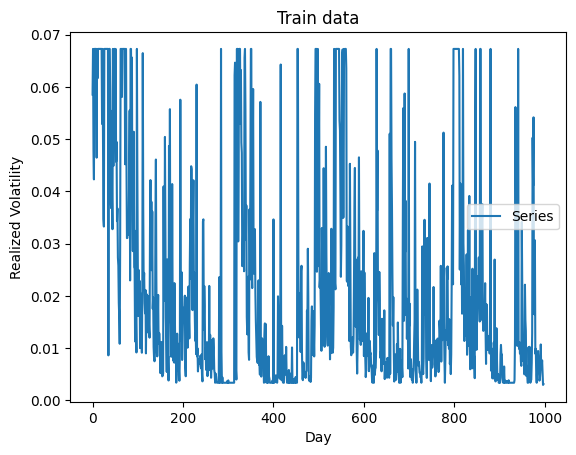

In [ ]:
plot_line_series(ytrain, 'Day', 'Realized Volatility', 'Train data')

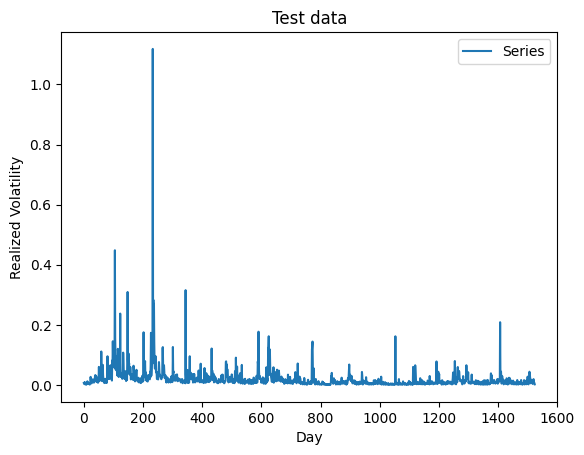

In [ ]:
plot_line_series(ytest, 'Day', 'Realized Volatility', 'Test data')

## *Clusterização Fuzzy via GK Algorithm*

In [ ]:
%%R

#' @title Clusterização Fuzzy com Gustafson-Kessel
#' @description
#' Executa o algoritmo de clusterização fuzzy Gustafson–Kessel (GK) com inicialização por k-means++ e pertinências fuzzy aleatórias.
#' A função também calcula, manualmente, as matrizes de dispersão (\eqn{\Sigma_j}) e os desvios padrão por dimensão para cada cluster.
#'
#' @param x Um data.frame ou matriz numérica com n amostras (linhas) e d variáveis (colunas).
#' @param k Um inteiro representando o número de clusters (ou regras fuzzy).
#'
#' @return Uma lista com três elementos:
#' \describe{
#'   \item{\code{centros}}{Matriz \code{k x d} contendo os centros finais de cada cluster.}
#'   \item{\code{pertinencias}}{Matriz \code{n x k} com os graus de pertinência fuzzy das amostras aos clusters.}
#'   \item{\code{desvios}}{Lista de \code{k} matrizes \code{d x d}, cada uma representando a matriz de dispersão ponderada (\eqn{\Sigma_j}) de um cluster.}
#' }
#'
#' @details
#' A função usa:
#' \itemize{
#'   \item \code{ppclust::gk} para a execução do algoritmo GK;
#'   \item \code{inaparc::kmpp} para inicialização dos centros;
#'   \item \code{inaparc::imembrand} para inicialização da matriz de pertinência.
#' }
#' O expoente de fuzzificação \code{m} é fixado em 2. As matrizes de dispersão são calculadas usando os pesos fuzzy elevados a \code{m}, conforme a definição clássica.
#'

gk_clustering <- function(x, k) {
  # Carrega o pacote 'ppclust', que fornece implementações de algoritmos de clusterização fuzzy,
  # como Fuzzy C-Means (FCM), Gustafson–Kessel (GK), entre outros.
  library(ppclust)

  # Carrega o pacote 'inaparc', que provê métodos de inicialização de centros e pertinências,
  # como k-means++ (kmpp) e inicialização fuzzy aleatória (imembrand).
  library(inaparc)

  # Garante que k seja um escalar inteiro válido
  k <- as.integer(as.numeric(k[1]))

  # ----------- Inicialização dos clusters -----------

  # Semente para reprodutibilidade de resultados
  set.seed(123)

  # Inicializa os centros dos clusters com o algoritmo k-means++.
  # Retorna uma lista com vários componentes; o '$v' acessa a matriz dos centros inicializados (k x d).
  v <- kmpp(x, k = k)$v

  # Inicializa a matriz de pertinência fuzzy (n x k), onde cada linha soma 1.
  # Essa matriz define o grau de associação inicial de cada amostra a cada cluster.
  u <- imembrand(nrow(x), k = k)$u

  # ----------- Execução do algoritmo Gustafson-Kessel -----------

  # Executa o algoritmo GK (fuzzy clustering com métricas de covariância adaptativas).
  # Argumentos principais:
  # - x: conjunto de dados
  # - centers: centros inicializados (matriz k x d)
  # - memberships: matriz de pertinência inicial (n x k)
  # - m: expoente de fuzzificação (m > 1; m = 2 é o padrão mais usado)
  # - dmetric: métrica de distância ("sqeuclidean" = euclidiana ao quadrado)
  # - iter.max: número máximo de iterações
  # - con.val: critério de convergência (parar se mudança entre iterações < 1e-9)
  gk.res <- gk(x, centers = v, memberships = u, m = 2,
              dmetric = "sqeuclidean", iter.max = 1000, con.val = 1e-9)

  # Exporta a matriz de centros finais (k x d) para uso posterior
  centros <- gk.res$v

  # Exporta a matriz final de pertinência fuzzy (n x k)
  pertinencias <- gk.res$u

  # ----------- Cálculo manual das matrizes de dispersão (Σ_j) e desvios padrão -----------

  # Converte os dados para uma matriz numérica (n x d), onde:
  # n = número de amostras (linhas), d = número de variáveis (lags ou dimensões)
  X <- as.matrix(x)

  # Recupera a matriz de pertinência fuzzy (n x k), onde:
  # U[i, j] representa o grau de associação da amostra i ao cluster j
  U <- gk.res$u

  # Recupera a matriz de centros dos clusters (k x d), onde:
  # V[j, ] contém as coordenadas do centro do cluster j
  V <- gk.res$v

  # Expoente de fuzzificação usado tanto no algoritmo quanto neste cálculo
  m <- 2

  # Define as dimensões principais do problema
  n <- nrow(X)   # número de amostras
  k <- ncol(U)   # número de clusters
  d <- ncol(X)   # número de variáveis (dimensões)

  # Inicializa uma lista que armazenará a matriz de dispersão Σ_j de cada cluster j
  Sigma_list <- vector("list", k)

  # Loop principal: calcula Σ_j para cada cluster j
  for (j in 1:k) {

    # Inicializa o numerador e denominador da fórmula de Σ_j
    # Σ_j = ( ∑_{i=1}^{n} (u_ij)^m * (x_i - v_j)(x_i - v_j)^T ) / ∑_{i=1}^{n} (u_ij)^m
    num <- matrix(0, d, d)  # acumulador da soma ponderada das covariâncias
    denom <- 0              # acumulador da soma dos pesos (u_ij^m)

    # Loop interno: percorre todas as amostras i
    for (i in 1:n) {

      # Calcula o grau de pertinência fuzzy elevado ao expoente m
      u_ij_m <- U[i, j]^m

      # Calcula o vetor de diferença entre a amostra i e o centro do cluster j:
      # diff = x_i - v_j (vetor coluna d x 1)
      diff <- matrix(X[i, ] - V[j, ], ncol = 1)

      # Atualiza o numerador com a contribuição da amostra i:
      # u_ij^m * (diff * diffᵗ) → matriz d x d (produto externo)
      num <- num + u_ij_m * (diff %*% t(diff))

      # Atualiza o denominador com o peso u_ij^m
      denom <- denom + u_ij_m
    }

    # Finaliza o cálculo da matriz de dispersão Σ_j:
    # divide o somatório ponderado das covariâncias pelo total de pesos
    Sigma_list[[j]] <- num / denom
  }

  # Exporta os desvios padrão com o nome 'desvios'
  desvios <- Sigma_list

  return(list(
  centros = centros,
  pertinencias = pertinencias,
  desvios = desvios
  ))

}

In [ ]:
def run_gk_clustering(X_train: pd.DataFrame, rules_number: int):
    """
      Description:
          Executa a função R 'gk_clustering' para realizar clusterização fuzzy com o algoritmo
          Gustafson–Kessel. Retorna os centros dos clusters, as pertinências fuzzy e os desvios
          padrão por dimensão de cada cluster, extraídos das matrizes de covariância.

      Args:
          X_train (pd.DataFrame): Conjunto de dados com colunas defasadas (ex: 'lag1', 'lag2', ...).
          rules_number (int): Número de clusters ou regras fuzzy (k).

      Return:
          Tuple contendo:
              - centers_df (pd.DataFrame): Matriz (k x d) com os centros finais dos clusters.
              - memberships_df (pd.DataFrame): Matriz (n x k) de pertinência fuzzy das amostras.
              - sigmas (np.ndarray): Matriz (k x d) com os desvios padrão por dimensão para cada cluster.
    """

    # Garante que Xtrain seja um DataFrame, mesmo que seja um array
    X_train = pd.DataFrame(X_train) if not isinstance(X_train, pd.DataFrame) else X_train

    # Se quiser, nomeie automaticamente as colunas como lag1, lag2, ..., lagN
    if X_train.columns.dtype == 'int':
        X_train.columns = [f"lag{i+1}" for i in range(X_train.shape[1])]

    pandas2ri.activate()  # Ativa a conversão automática entre pandas DataFrame (Python) e data.frame (R)

    # Envia o DataFrame Xtrain para o ambiente global do R com o nome 'x'
    globalenv["x"] = pandas2ri.py2rpy(X_train)

    # Envia o número de clusters/regras para o R como vetor inteiro, com o nome 'rules_number'
    globalenv["k"] = int(rules_number)

    # Executa a função R declarada anteriormente
    r_result = r("gk_clustering(x, k[[1]])")

    centers = r_result.rx2("centros")
    memberships = r_result.rx2("pertinencias")
    desvios = r_result.rx2("desvios")

    centers_df = pd.DataFrame(centers, columns=X_train.columns)
    memberships_df = pd.DataFrame(memberships)
    std_devs = [np.array(desvios[i]) for i in range(len(desvios))]

    # Converte cada matriz R da lista para um array NumPy
    # Cada elemento da lista representa a matriz de covariância (d x d) de um cluster
    sigmas = [np.array(dev) for dev in desvios]

    # Extrai os desvios padrão (raiz quadrada das variâncias) de cada matriz de covariância
    # Isso gera uma lista de vetores 1D, onde cada vetor contém os desvios padrão por dimensão
    sigmas = [np.sqrt(np.diag(S)) for S in sigmas]

    # Concatena a lista de vetores em um array 2D (n_clusters x n_features)
    # Isso facilita o acesso via sigmas[i, j] para a dimensão j do cluster i
    sigmas = np.array(sigmas)  # shape: (n_clusters, n_features)

    return centers_df, memberships_df, sigmas

In [ ]:
centers_df, memberships_df, sigmas = run_gk_clustering(Xtrain, rules_number)

In [ ]:
centers_df

,lag1,lag2
0,0.003389,0.004435
1,0.048532,0.028164
2,0.067249,0.067249


In [ ]:
memberships_df

,0,1,2
0,0.113821,0.544715,0.341463
1,0.467290,0.401869,0.130841
2,0.121359,0.436893,0.441748
3,0.317972,0.419355,0.262673
4,0.474227,0.046392,0.479381
...,...,...,...
993,0.581250,0.350000,0.068750
994,0.497382,0.319372,0.183246
995,0.323308,0.390977,0.285714
996,0.403727,0.434783,0.161491


In [ ]:
sigmas

array([[0.02856924, 0.02781192],
       [0.03449554, 0.02105303],
       [0.05025619, 0.04979936]])

In [ ]:
# Garante que Xtrain seja um DataFrame, mesmo que seja um array
X_train = pd.DataFrame(Xtrain) if not isinstance(Xtrain, pd.DataFrame) else Xtrain

# Se quiser, nomeie automaticamente as colunas como lag1, lag2, ..., lagN
if X_train.columns.dtype == 'int':
    X_train.columns = [f"lag{i+1}" for i in range(X_train.shape[1])]

**Interpretação da Elipse no Cluster Fuzzy**

Nos gráficos gerados para cada cluster fuzzy, a elipse preta representa **a forma e dispersão estatística geral do cluster**.

**O que ela representa:**
- A elipse é construída com base na **matriz de covariância ponderada** pelas pertinências fuzzy dos pontos ao cluster.
- Isso significa que **todos os pontos contribuem** para a formação da elipse, independentemente do seu grau de pertencimento.
- A forma da elipse reflete a **orientação e extensão do cluster** no espaço (ex: direção de maior variação dos dados).

**O que ela _não_ representa:**
- **Não é um contorno de decisão**, nem uma fronteira de pertinência como "região de >50%".
- **Pontos com pertinência maior que 50% podem aparecer fora da elipse**, pois a dispersão global considera também pontos com baixa pertinência (com menor peso).

**Em resumo,**
> A elipse é uma ferramenta visual para entender a **forma estatística do cluster**, e não um limite direto de associação fuzzy.

Se for necessário representar visualmente **fronteiras de pertinência**, isso exigiria o cálculo de **níveis de isopertinência**, o que não é feito neste gráfico.


In [ ]:
figs = plot_gk_clusters_2D(X_train, centers_df.to_numpy(), memberships_df.to_numpy())

for fig in figs:
  fig.show()

In [ ]:
figs = plot_gk_clusters_high_membership(X_train, centers_df.to_numpy(), memberships_df.to_numpy())

for fig in figs:
  fig.show()

# ***Implementação do modelo***

## *Treinamento e teste do modelo*

In [ ]:
# Treina o modelo.
OT, norm, u, P = train_model(
    Xtrain=Xtrain,
    ytrain=ytrain,
    r=rules_number,
    lamb=lamb,
    alfa=alfa,
    kz=kz,
    zs=zs,
    centers=centers_df.to_numpy(),
    sigmas=sigmas
)

CPU execution time (training): 0.06585914900000134 seconds


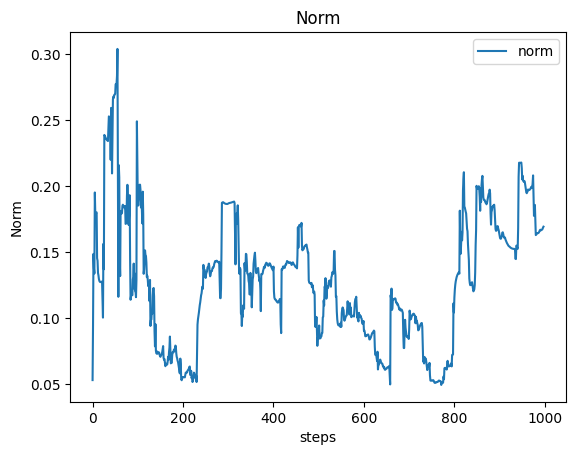

In [ ]:
# Exibe a evolução da norma ao longo dos passos.
plot_line_series(norm, 'steps', 'Norm', 'Norm', 'norm')

In [ ]:
# Exibe algumas métricas de erro de treinamento.
print('mse  train =', mean_squared_error(ytrain, OT))
print('nrms train =', root_mean_squared_error(ytrain, OT)/ytrain.std())
print('rmse train =', root_mean_squared_error(ytrain, OT))
print('mae  train =', mean_absolute_error(ytrain, OT))

mse  train = 0.00017218549610626367
nrms train = 0.6397333815637788
rmse train = 0.013121947115663272
mae  train = 0.009246055883298321


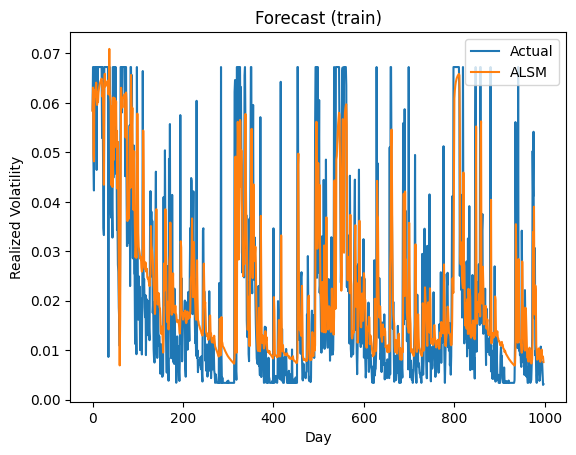

In [ ]:
# Plota a série temporal prevista pelo modelo ALSM durante o treinamento em comparação com os valores reais (ytrain).
plot_comparison_series(ytrain, OT, 'Day', 'Realized Volatility', 'Forecast (train)', ('Actual', 'ALSM'))

In [ ]:
# Testa o modelo.
OS = test_model(
    Xtest=Xtest,
    ytest=ytest,
    r=rules_number,
    lamb=lamb,
    P=P,
    u=u,
    centers=centers_df.to_numpy(),
    sigmas=sigmas
)

CPU execution time (testing): 0.06356597999999991 seconds


In [ ]:
# Exibe algumas métricas de erro de teste.
print('MSE   test =', mean_squared_error(ytest, OS))
print('NRMSE test =', root_mean_squared_error(ytest, OS)/ytest.std())
print('RMSE  test =', root_mean_squared_error(ytest, OS))
print('MAE   test =', mean_absolute_error(ytest, OS))

MSE   test = 0.0011423822276457683
NRMSE test = 0.8180228259659611
RMSE  test = 0.033799145368570614
MAE   test = 0.011526364578134064


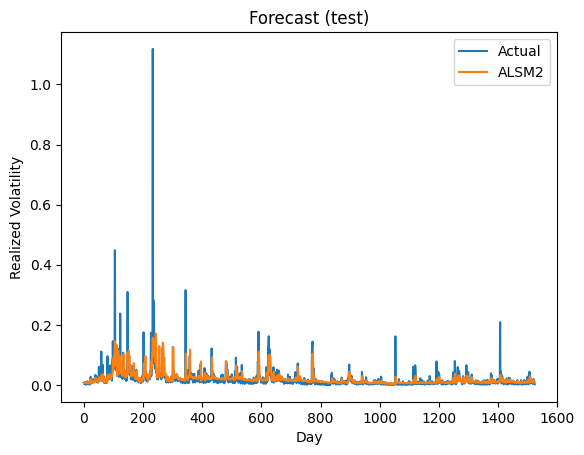

In [ ]:
# Plota a série temporal prevista pelo modelo ALSM durante o teste em comparação com os valores reais (ytest).
plot_comparison_series(ytest, OS, 'Day', 'Realized Volatility', 'Forecast (test)', ('Actual', 'ALSM2'))

# ***Otimização de hiperparâmetros***

## *Grid-Search*

In [ ]:
# Define os ranges a serem testados
delays = range(1, 31)
rules_options = range(1, 31)

# Lista para armazenar os resultados
grid_search_results = []

for delay in delays:
    # Gera os datasets defasados
    Xtrain, ytrain, Xtest, ytest = create_train_test_lagged_dataset(data, 0, n, n, m, delay)

    for rules_number in rules_options:
        try:
            # Clustering fuzzy
            centers_df, memberships_df, sigmas = run_gk_clustering(Xtrain, rules_number)

            # Treinamento do modelo
            OT, norm, u, P = train_model(
                Xtrain=Xtrain,
                ytrain=ytrain,
                r=rules_number,
                lamb=lamb,
                alfa=alfa,
                kz=kz,
                zs=zs,
                centers=centers_df.to_numpy(),
                sigmas=sigmas
            )

            # Calcula o RMSE
            rmse = root_mean_squared_error(ytrain, OT)

            # Armazena os resultados
            grid_search_results.append({
                "delay": delay,
                "rules_number": rules_number,
                "rmse": rmse
            })

            print(f"[OK] delay={delay}, rules={rules_number}, rmse={rmse:.5f}")

        except Exception as e:
            print(f"[ERRO] delay={delay}, rules={rules_number} → {e}")
            continue


In [ ]:
# Converte os resultados em DataFrame
grid_search_results_df = pd.DataFrame(grid_search_results)

# Ordena pelo menor RMSE
grid_search_results_df.sort_values(by="rmse", inplace=True)

# Salva os resultados em CSV
grid_search_results_df.to_csv("grid_search_results.csv", index=False)

# Faz o download do CSV criado
files.download("grid_search_results.csv")

In [ ]:
grid_search_results_df

## *Otimização Bayesiana*

In [ ]:
# Define o espaço de busca
space = [
    Integer(1, 101, name='delay'),
    Integer(1, 101, name='rules_number')
]

@use_named_args(space)
def objective(delay, rules_number):
    try:
        # Gera os datasets defasados
        Xtrain, ytrain, Xtest, ytest = create_train_test_lagged_dataset(data, 0, n, n, m, delay)

        centers_df, memberships_df, sigmas = run_gk_clustering(Xtrain, rules_number)

        OT, norm, u, P = train_model(
            Xtrain=Xtrain,
            ytrain=ytrain,
            r=rules_number,
            lamb=lamb,
            alfa=alfa,
            kz=kz,
            zs=zs,
            centers=centers_df.to_numpy(),
            sigmas=sigmas
        )

        rmse = root_mean_squared_error(ytrain, OT)
        return rmse

    except Exception as e:
        print(f"[ERRO] delay={delay}, rules={rules_number} → {e}")
        return 1e5  # penalização em caso de falha

# Executa a otimização
bayesian_results = gp_minimize(objective, space, n_calls=30, random_state=42)

In [ ]:
# Constrói o DataFrame com os parâmetros testados e seus respectivos RMSEs
bayesian_results_df = pd.DataFrame(bayesian_results.x_iters, columns=['delay', 'rules_number'])
bayesian_results_df['rmse'] = bayesian_results.func_vals

# Ordena pelo menor RMSE
bayesian_results_df.sort_values(by='rmse',inplace=True)

# Salva os resultados em CSV
bayesian_results_df.to_csv('bayesian_optimization_results.csv', index=False)

# Faz o download do CSV criado
files.download("bayesian_optimization_results.csv")

In [ ]:
bayesian_results_df

## *Algoritmos Genéticos*

In [ ]:
# Espaço de busca
LOW_DELAY, HIGH_DELAY = 1, 101
LOW_RULES, HIGH_RULES = 1, 101

# Define o problema (minimizar RMSE)
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_delay", random.randint, LOW_DELAY, HIGH_DELAY)
toolbox.register("attr_rules", random.randint, LOW_RULES, HIGH_RULES)
toolbox.register("individual", tools.initCycle, creator.Individual, (toolbox.attr_delay, toolbox.attr_rules), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Lista para armazenar os resultados
genetic_algorithm_results = []

# Atualiza a função de avaliação para salvar os resultados
def evaluate(individual):
    delay, rules_number = individual
    try:
        Xtrain, ytrain, Xtest, ytest = create_train_test_lagged_dataset(data, 0, n, n, m, delay)

        centers_df, memberships_df, sigmas = run_gk_clustering(Xtrain, rules_number)

        OT, norm, u, P = train_model(
            Xtrain=Xtrain,
            ytrain=ytrain,
            r=rules_number,
            lamb=lamb,
            alfa=alfa,
            kz=kz,
            zs=zs,
            centers=centers_df.to_numpy(),
            sigmas=sigmas
        )

        rmse = root_mean_squared_error(ytrain, OT)
    except Exception as e:
        rmse = 1e5  # penalidade

    # Salva o resultado no log
    genetic_algorithm_results.append({
        'delay': delay,
        'rules_number': rules_number,
        'rmse': rmse
    })

    return (rmse,)

# Registro do operador
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxUniform, indpb=0.5)
toolbox.register("mutate", tools.mutUniformInt, low=[LOW_DELAY, LOW_RULES], up=[HIGH_DELAY, HIGH_RULES], indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Execução
pop = toolbox.population(n=20)
algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=10, verbose=True)

In [ ]:
# Converte os resultados em DataFrame
genetic_algorithm_results_df = pd.DataFrame(genetic_algorithm_results)

# Ordena pelo menor RMSE
genetic_algorithm_results_df.sort_values(by='rmse', inplace=True)

# Salva os resultados em CSV
genetic_algorithm_results_df.to_csv("genetic_algorithm_results.csv", index=False)

# Faz o download do CSV criado
files.download("genetic_algorithm_results.csv")

# ***Resultados da otimização de hiperparâmetros***

## *Resultados da otimização de hiperparâmetros via grid search*

In [ ]:
#
grid_search_results_df = pd.read_csv('grid_search_results.csv')
#
bayesian_results_df = pd.read_csv('bayesian_optimization_results.csv')
#
genetic_algorithm_results_df = pd.read_csv('genetic_algorithm_results.csv')

In [ ]:
#
grid_search_results_df.sort_values(by="rmse", inplace=True)
#
bayesian_results_df.sort_values(by="rmse", inplace=True)
#
genetic_algorithm_results_df.sort_values(by="rmse", inplace=True)

In [ ]:
grid_search_results_df

,delay,rules_number,rmse
1294,13,100,0.00605
1097,11,100,0.00608
1889,19,100,0.00609
1286,13,99,0.00610
1088,11,99,0.00612
...,...,...,...
2768,28,96,0.38276
2755,28,83,0.39301
2771,28,99,0.41922
2779,28,100,0.41940


In [ ]:
plot_surface_3d(
    x=grid_search_results_df['delay'],
    y=grid_search_results_df['rules_number'],
    z=grid_search_results_df['rmse'],
    title='Superfície RMSE',
    xlabel='Delay',
    ylabel='Regras',
    zlabel='RMSE'
)

In [ ]:
fixed_value = 14
plot_rmse_curve_fixed_param(
    x=grid_search_results_df['delay'],
    y=grid_search_results_df['rules_number'],
    z=grid_search_results_df['rmse'],
    fix_var='x',
    fixed_value=fixed_value,
    xlabel='Número de Regras',
    title=f'RMSE vs Número de Regras (Delay = {fixed_value})'
)

In [ ]:
fixed_value=8
plot_rmse_curve_fixed_param(
    x=grid_search_results_df['delay'],
    y=grid_search_results_df['rules_number'],
    z=grid_search_results_df['rmse'],
    fix_var='y',
    fixed_value=fixed_value,
    xlabel='Delay',
    title=f'RMSE vs Delay ({fixed_value} Regras)'
)

In [ ]:
# Mostra o melhor resultado encontrado
best_grid_search_result = grid_search_results_df.iloc[0]
print(f"\nMelhor combinação → delay={best_grid_search_result['delay']}, rules={best_grid_search_result['rules_number']}, RMSE={best_grid_search_result['rmse']:.5f}")


Melhor combinação → delay=13.0, rules=100.0, RMSE=0.00605


## *Resultados da otimização de hiperparâmetros via otimização bayesiana*

In [ ]:
bayesian_results_df = bayesian_results_df[bayesian_results_df['rmse'] != 100000.0]

In [ ]:
bayesian_results_df

,delay,rules_number,rmse
0,15,68,0.007345
1,7,73,0.007369
2,15,66,0.007418
3,101,100,0.007823
4,6,36,0.008767
5,101,67,0.009059
6,100,63,0.009880
7,3,59,0.010161
8,3,58,0.010162
9,3,53,0.010174


In [ ]:
plot_scatter_3d(
    x=bayesian_results_df['delay'],
    y=bayesian_results_df['rules_number'],
    z=bayesian_results_df['rmse'],
    title='Dispersão 3D dos Resultados',
    xlabel='Delay',
    ylabel='Regras',
    zlabel='RMSE'
)

In [ ]:
# Mostra o melhor resultado encontrado
best_bayesian_result = bayesian_results_df.iloc[0]
print(f"Melhor combinação → delay={best_bayesian_result['delay']}, rules={best_bayesian_result['rules_number']}, RMSE={best_bayesian_result['rmse']:.5f}")

Melhor combinação → delay=15.0, rules=68.0, RMSE=0.00734


## *Resultados da otimização de hiperparâmetros via algoritmos genéticos*

In [ ]:
genetic_algorithm_results_df

,delay,rules_number,rmse
0,12,75,0.007060
1,12,75,0.007060
2,12,75,0.007060
3,12,75,0.007060
4,12,75,0.007060
...,...,...,...
130,65,33,0.185476
131,61,65,0.203979
132,40,75,0.214660
133,45,41,0.233249


In [ ]:
plot_scatter_3d(
    x=genetic_algorithm_results_df['delay'],
    y=genetic_algorithm_results_df['rules_number'],
    z=genetic_algorithm_results_df['rmse'],
    title='Dispersão 3D dos Resultados',
    xlabel='Delay',
    ylabel='Regras',
    zlabel='RMSE'
)

In [ ]:
# Mostra o melhor resultado encontrado
best_genetic_algorithm_result = genetic_algorithm_results_df.iloc[0]
print(f"Melhor combinação → delay={best_genetic_algorithm_result['delay']}, rules={best_genetic_algorithm_result['rules_number']}, RMSE={best_genetic_algorithm_result['rmse']:.5f}")

Melhor combinação → delay=12.0, rules=75.0, RMSE=0.00706


## *Treinando o modelo com os melhores hiperparâmetros encontrados*

In [ ]:
best_result = best_grid_search_result # Por hipótese

for result in [best_grid_search_result, best_bayesian_result, best_genetic_algorithm_result]:
  if result['rmse'] < best_result['rmse']:
    best_result = result

best_result

,1294
delay,13.00000
rules_number,100.00000
rmse,0.00605


In [ ]:
best_result['delay'] = float(2)
best_result['rules_number'] = float(12)
best_result

/tmp/ipython-input-61-995466115.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-61-995466115.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,1294
delay,2.00000
rules_number,12.00000
rmse,0.00605


In [ ]:
# Inicializa Xtrain, ytrain, Xtest e ytest.
Xtrain, ytrain, Xtest, ytest = create_train_test_lagged_dataset(data, 0, n, n, m, int(best_result['delay'])
)

In [ ]:
centers_df, memberships_df, sigmas = run_gk_clustering(Xtrain, int(best_result['rules_number']))

In [ ]:
# Treina o modelo.
OT, norm, u, P = train_model(
    Xtrain=Xtrain,
    ytrain=ytrain,
    r=int(best_result['rules_number']),
    lamb=lamb,
    alfa=alfa,
    kz=kz,
    zs=zs,
    centers=centers_df.to_numpy(),
    sigmas=sigmas
)

CPU execution time (training): 0.18909514299999586 seconds


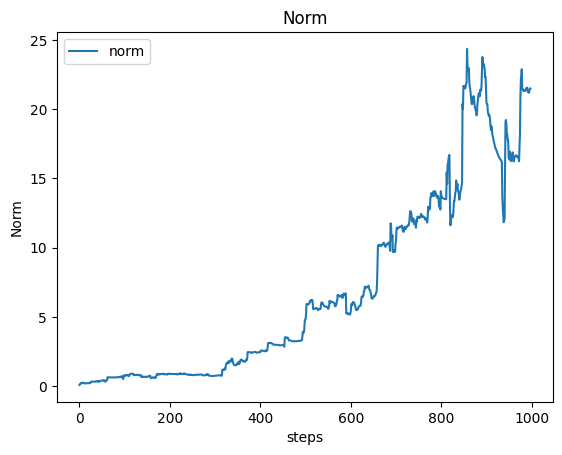

In [ ]:
# Exibe a evolução da norma ao longo dos passos.
plot_line_series(norm, 'steps', 'Norm', 'Norm', 'norm')

In [ ]:
# Exibe algumas métricas de erro de treinamento.
print('mse  train =', mean_squared_error(ytrain, OT))
print('nrms train =', root_mean_squared_error(ytrain, OT)/ytrain.std())
print('rmse train =', root_mean_squared_error(ytrain, OT))
print('mae  train =', mean_absolute_error(ytrain, OT))

mse  train = 0.00013634347679382147
nrms train = 0.5692694947857797
rmse train = 0.011676620949308129
mae  train = 0.008127167447647918


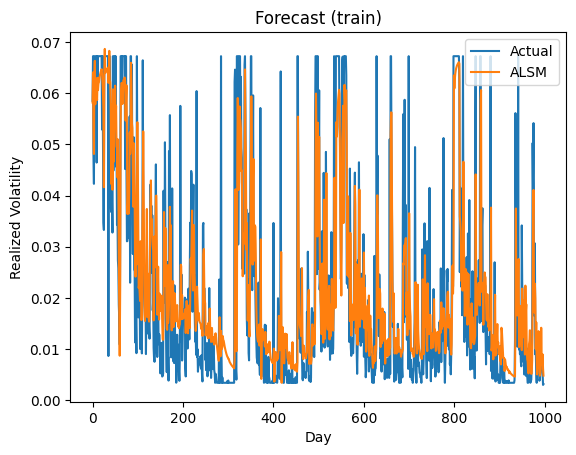

In [ ]:
# Plota a série temporal prevista pelo modelo ALSM durante o treinamento em comparação com os valores reais (ytrain).
plot_comparison_series(ytrain, OT, 'Day', 'Realized Volatility', 'Forecast (train)', ('Actual', 'ALSM'))

In [ ]:
# Testa o modelo.
OS = test_model(
    Xtest=Xtest,
    ytest=ytest,
    r=int(best_result['rules_number']),
    lamb=lamb,
    P=P,
    u=u,
    centers=centers_df.to_numpy(),
    sigmas=sigmas
)

CPU execution time (testing): 0.24749152599999746 seconds


In [ ]:
# Exibe algumas métricas de erro de teste.
print('MSE   test =', mean_squared_error(ytest, OS))
print('NRMSE test =', root_mean_squared_error(ytest, OS)/ytest.std())
print('RMSE  test =', root_mean_squared_error(ytest, OS))
print('MAE   test =', mean_absolute_error(ytest, OS))

MSE   test = 0.0007268822752650563
NRMSE test = 0.6525168676677263
RMSE  test = 0.026960754352670778
MAE   test = 0.009962609665605084


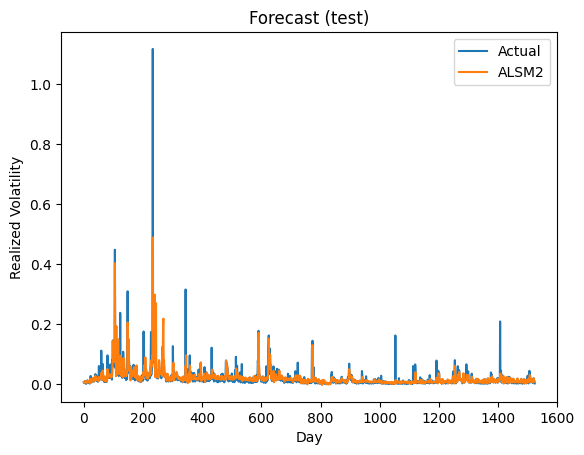

In [ ]:
# Plota a série temporal prevista pelo modelo ALSM durante o teste em comparação com os valores reais (ytest).
plot_comparison_series(ytest, OS, 'Day', 'Realized Volatility', 'Forecast (test)', ('Actual', 'ALSM2'))